In [1]:
import gudhi as gd
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import utils
from random import choice, sample
from rich import print

with open("data/aspartam.json", mode = "r") as drugbank:
    db = json.load(drugbank)

### Model as Gaussian mixtures
The $\sigma$ in the gaussian mixtures controls the standard deviation of the gaussian with peak around each mass spectrum peak. If this is large the nearby peaks in the same energy level will "blend" together, which exhibits topological features across energy levels. However, for very large $\sigma$, all mass spectra will look the same topologically.

The $\sigma$ in the sampling domain controls the interval around a peak which is "relevant". For instance, if this is $\sigma = 1.0080$ then we might interpret this as looking for molecules around this peak which have one less or one more ionised hydrogen atoms.

In [2]:
mixtures = list()
xdomains = list()
n_samples = 1000
for m in tqdm(list(db.keys())):
    mixtures.append(utils.create_gaussian_mixtures(
        (db[m]["energy0"], db[m]["energy1"], db[m]["energy2"]),
        sigma = 2 # deviation of gaussian around peak
    ))
    xdomains.append(utils.create_sampling_domain(
        (db[m]["energy0"], db[m]["energy1"], db[m]["energy2"]),
        sigma = 2,    # sampling standard deviation
        N = n_samples, # total number of points to sample
    ))

  0%|          | 0/10 [00:00<?, ?it/s]

### Sample point cloud from mixture of a random molecule

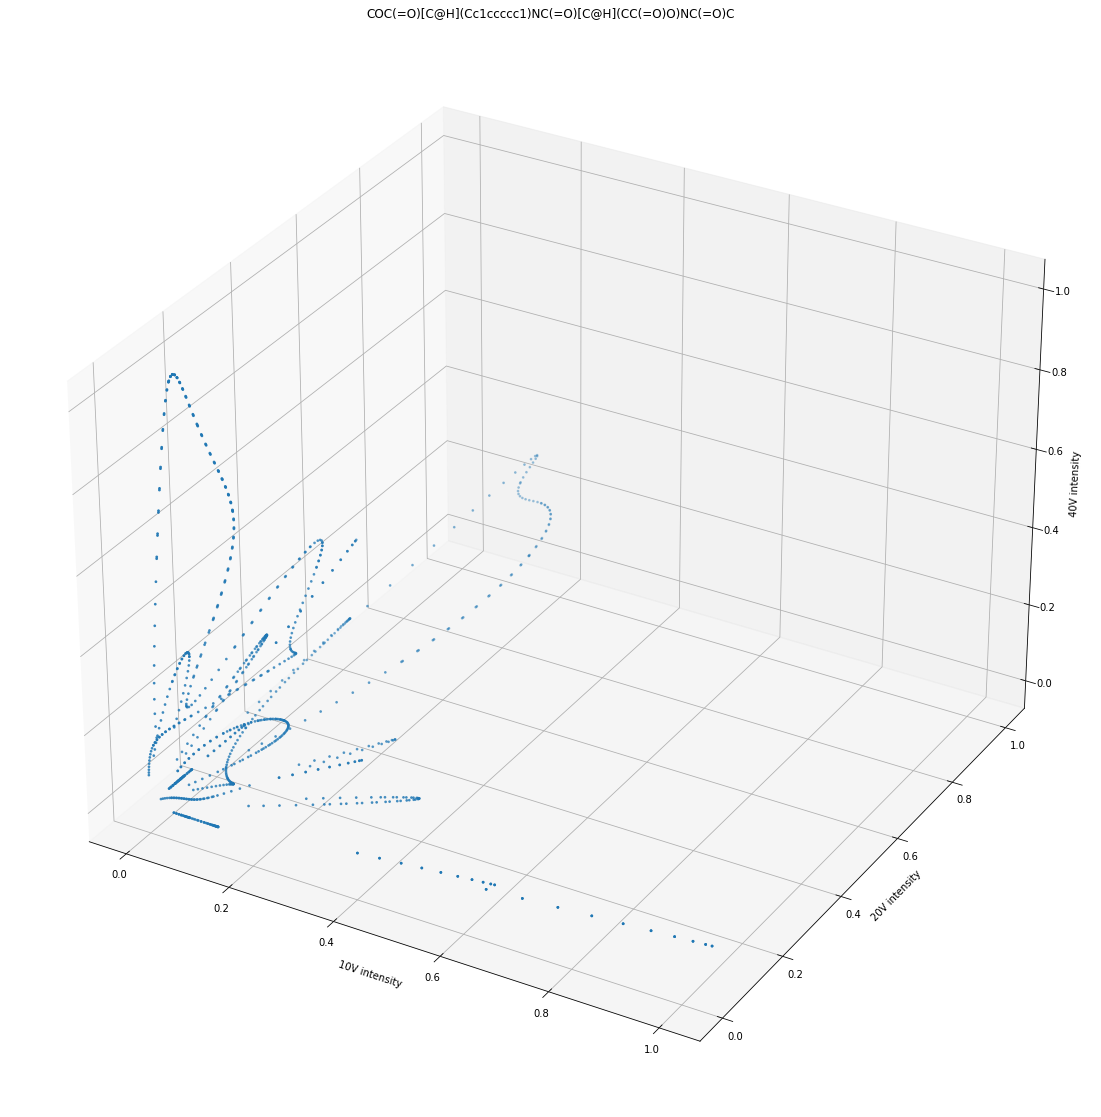

In [3]:
%matplotlib inline

mol_idx = choice(list(range(len(mixtures))))
mol_str = list(db.keys())[mol_idx]
ms = mixtures[mol_idx]
x_def = xdomains[mol_idx]

X = np.zeros((n_samples, 3))
X[:,0], X[:,1], X[:,2] = ms[0](x_def), ms[1](x_def), ms[2](x_def)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection = "3d")
ax.scatter(X[:,0], X[:,1], X[:,2], s= 3)
ax.set_title(mol_str)
ax.set_xlabel("10V intensity")
ax.set_ylabel("20V intensity")
ax.set_zlabel("40V intensity")
plt.show()

17753 33078 16320

<IPython.core.display.Javascript object>


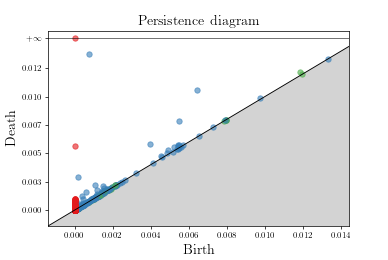

In [7]:
%matplotlib notebook
def compute(X):    
    skeleton = gd.AlphaComplex(
        points = X,
    )
    st = skeleton.create_simplex_tree()
    return st

st = compute(X)

lines = [tau for tau,_ in st.get_simplices() if len(tau) == 2]
triangles = [tau for tau,_ in st.get_simplices() if len(tau) == 3]
tetrahedrons = [tau for tau,_ in st.get_simplices() if len(tau) == 4]

print(len(lines), len(triangles), len(tetrahedrons))

diag = st.persistence()
gd.plot_persistence_diagram(diag)
plt.show()